# Installs and Imports

In [4]:
!pip install opendatasets --upgrade --quiet

In [5]:
import os
import cv2
import opendatasets as od

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

# Download and Prepare Dataset, DataLoader

In [6]:
DOWNLOAD_URL = "https://www.kaggle.com/splcher/animefacedataset"
od.download(DOWNLOAD_URL)

100%|██████████| 395M/395M [00:02<00:00, 191MB/s]


In [7]:
DATA_DIR = "./animefacedataset"

print(os.listdir(DATA_DIR))
print(len(os.listdir(DATA_DIR + "/images")))
print(os.listdir(DATA_DIR + "/images")[:10])

['images']
63565
['21156_2008.jpg', '45205_2014.jpg', '28121_2009.jpg', '35123_2011.jpg', '35694_2011.jpg', '52085_2015.jpg', '8497_2004.jpg', '58492_2017.jpg', '42606_2013.jpg', '22470_2008.jpg']


In [8]:
image_size = 64
# Try to calculate the stats from the dataset
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

tfms = T.Compose([T.Resize(image_size),
                  T.CenterCrop(image_size),
                  T.ToTensor(),
                  T.Normalize(*stats)])

train_ds = ImageFolder(DATA_DIR, transform=tfms)
train_ds[0]

(tensor([[[ 0.6784,  0.6706,  0.8118,  ...,  1.0000,  0.9765,  0.9529],
          [ 0.8431,  0.9294,  0.9922,  ...,  0.9765,  0.9843,  1.0000],
          [ 0.9216,  0.9843,  0.9922,  ...,  0.9843,  0.9922,  1.0000],
          ...,
          [-0.0902, -0.1137, -0.2549,  ..., -0.1373, -0.2784, -0.5137],
          [-0.0510, -0.1451, -0.2941,  ..., -0.1686, -0.3176, -0.5922],
          [-0.0431, -0.1451, -0.3176,  ..., -0.2235, -0.3569, -0.6471]],
 
         [[ 0.6471,  0.6471,  0.7725,  ...,  0.7961,  0.7804,  0.7647],
          [ 0.8118,  0.8902,  0.9765,  ...,  0.7412,  0.7569,  0.7882],
          [ 0.8510,  0.9137,  0.9137,  ...,  0.7020,  0.7255,  0.7725],
          ...,
          [-0.1608, -0.1922, -0.3176,  ..., -0.2392, -0.3804, -0.6235],
          [-0.1451, -0.2235, -0.3725,  ..., -0.2471, -0.3961, -0.6784],
          [-0.1529, -0.2392, -0.3961,  ..., -0.3020, -0.4353, -0.7333]],
 
         [[ 0.6235,  0.6078,  0.7255,  ...,  0.7490,  0.7412,  0.7490],
          [ 0.7804,  0.8431,

In [9]:
BATCH_SIZE = 128

train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)

In [10]:
def denorm(img_tensors):
  means, stds = stats
  means = torch.as_tensor(means).reshape(1, 3, 1, 1)
  stds = torch.as_tensor(means).reshape(1, 3, 1, 1)
  return img_tensors * stds + means


def show_images(images, nmax=64):
  figure, ax = plt.subplots(figsize=(12, 12))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))


def show_dl(dl):
  for images, _ in dl:
    show_images(images)
    break

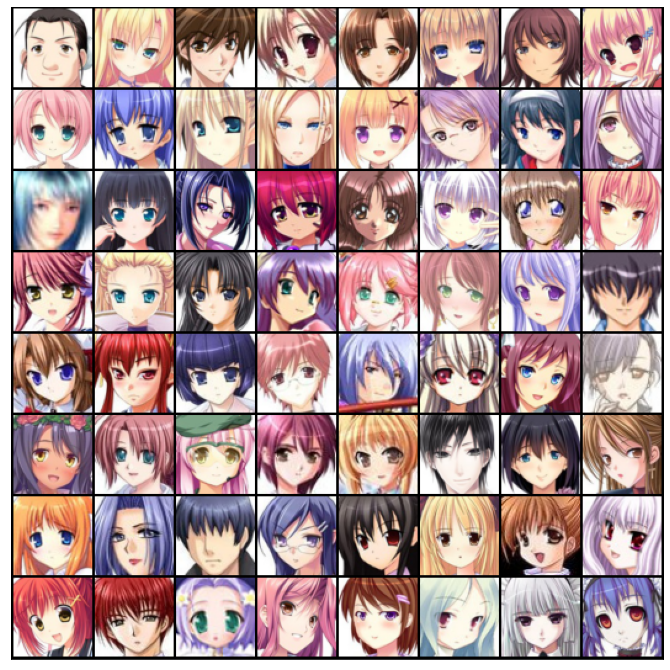

In [11]:
show_dl(train_dl)

# GPU and DeviceDataLoader

In [12]:
def get_device():
  """Pick GPU if GPU is available, else pick CPU"""
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")


def to_device(data, device):
  """Move Tensors to specified device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)


class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for batch in self.dl:
      yield to_device(batch, self.device)

  def __len__(self):
    """Returns the number of batches in the dataloader"""
    return len(self.dl)

In [13]:
device = get_device()
device

device(type='cuda')

In [14]:
train_loader = DeviceDataLoader(train_dl, device)

# Discriminator, Generator Network

In [15]:
from torch.nn.modules.batchnorm import BatchNorm1d
discriminator = nn.Sequential(
    # in_size: 3 x 64 x 64
    
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out_size: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out_size: 128 x 16 x16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out_size: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out_size: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out_size: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

discriminator = to_device(discriminator, device)

In [16]:
LATENT_SIZE = 128

generator = nn.Sequential(
    # LATENT_SIZE x 1 x 1

    nn.ConvTranspose2d(LATENT_SIZE, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out_size 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out_size: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out_size: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out_size: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out_size: 3 x 64 x 64
    )

generator = to_device(generator, device)

torch.Size([128, 3, 64, 64])


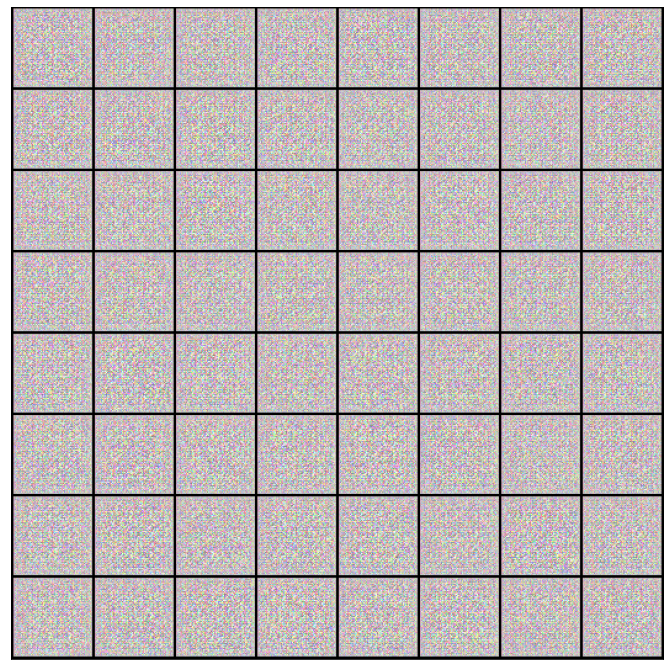

In [17]:
xb = to_device(torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1), device)
fake_images = generator(xb)
fake_images = denorm(fake_images.cpu().detach())
show_images(fake_images)
print(fake_images.shape)

# Training

In [18]:
def train_discriminator(real_images, opt_d):
  # Clear discriminator gradients
  opt_d.zero_grad()

  # Pass real images through discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  # Generate fake images
  latent_tensor = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
  fake_images = generator(latent_tensor)

  # Pass fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  # Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()

  return loss.item(), real_score, fake_score


In [19]:
def train_generator(opt_g):
  # Clear generator gradients
  opt_g.zero_grad()

  # Generate fake images
  latent_tensor = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
  fake_images = generator(latent_tensor)

  # Try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(BATCH_SIZE, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  # Update generator weights
  loss.backward()
  opt_g.step()

  return loss.item()


In [20]:
sample_dir = "generated"

os.makedirs(sample_dir, exist_ok=True)

In [21]:
def save_samples(index, latent_tensor, show=True):
  fake_images = generator(latent_tensor)
  fake_fname = "generated-images-{0:0=4d}.png".format(index)
  save_image(denorm(fake_images.cpu().detach()), os.path.join(sample_dir, fake_fname), nrow=8)
  print("Saving", fake_fname)
  if show:
    figure, ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(fake_images.cpu().detach()), nrow=8).permute(1, 2, 0))


In [22]:
FIXED_LATENT = torch.randn(64, LATENT_SIZE, 1, 1, device=device)

Saving generated-images-0000.png


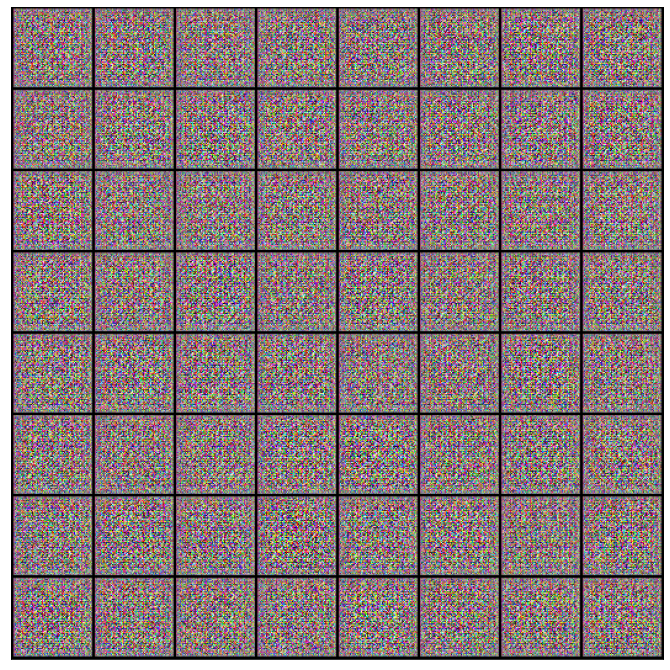

In [23]:
save_samples(0, FIXED_LATENT)

### Full Training Loop

In [24]:
def fit(epochs, lr, start_idx=1):
  torch.cuda.empty_cache()

  # Losses and Scores
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  opt_d = torch.optim.Adam(discriminator.parameters(), 
                           lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), 
                           lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for images, _ in tqdm(train_loader):
      # Train Discriminator
      loss_d, real_score, fake_score = train_discriminator(images, opt_d)
      
      # Train generator
      loss_g = train_generator(opt_g)

    # Recored losses and scores
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)
    
    # Log losses and scores (last batch)
    print("Epoch [{}/{}] loss_g {:.4f} loss_d {:.4f} fake_score {:.4f} real_score {:.4f}".
          format(epoch+1, epochs, loss_g, loss_d, fake_score, real_score))

    save_samples(epoch+start_idx, FIXED_LATENT, show=False)

  return losses_g, losses_d, real_scores, fake_scores


In [25]:
lr = 0.0002
epochs = 10

In [26]:
history = fit(epochs, lr, 1)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/10] loss_g 4.0959 loss_d 0.2571 fake_score 0.1049 real_score 0.8884
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/10] loss_g 5.9452 loss_d 0.2940 fake_score 0.1145 real_score 0.8725
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/10] loss_g 4.9773 loss_d 0.3502 fake_score 0.0220 real_score 0.7763
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/10] loss_g 3.6199 loss_d 0.3780 fake_score 0.0497 real_score 0.7608
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/10] loss_g 4.4156 loss_d 0.1988 fake_score 0.0411 real_score 0.8842
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/10] loss_g 5.0549 loss_d 0.0766 fake_score 0.0509 real_score 0.9818
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/10] loss_g 6.0290 loss_d 0.1702 fake_score 0.0198 real_score 0.8884
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/10] loss_g 5.8783 loss_d 0.0621 fake_score 0.0108 real_score 0.9554
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/10] loss_g 19.3523 loss_d 0.0210 fake_score 0.0001 real_score 0.9812
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/10] loss_g 8.1320 loss_d 0.1144 fake_score 0.0980 real_score 0.9947
Saving generated-images-0010.png


# Save the Model

In [27]:
torch.save(generator.state_dict(), "G.pth")
torch.save(discriminator.state_dict(), "D.pth")

# Model Analysis

In [28]:
losses_g, losses_d, real_scores, fake_scores = history

Text(0.5, 1.0, 'Losses vs. Epochs')

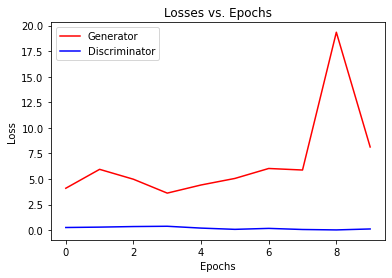

In [29]:
plt.plot(losses_g, "-r")
plt.plot(losses_d, "-b")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Generator", "Discriminator"])
plt.title("Losses vs. Epochs")

Text(0.5, 1.0, 'Scores vs. Epochs')

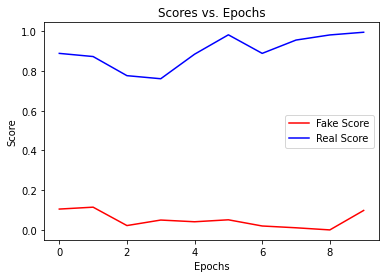

In [30]:
plt.plot(fake_scores, "-r")
plt.plot(real_scores, "-b")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend(["Fake Score", "Real Score"])
plt.title("Scores vs. Epochs")

In [31]:
from IPython.display import Image

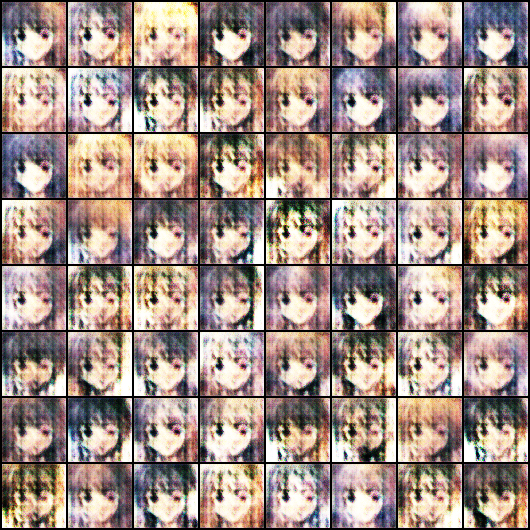

In [42]:
Image("./generated/generated-images-0001.png")

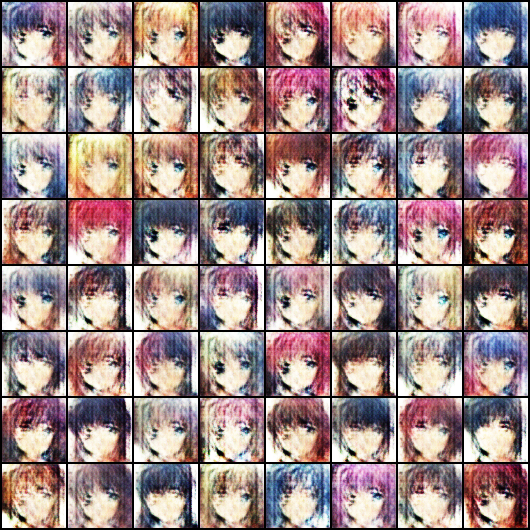

In [50]:
Image("./generated/generated-images-0002.png")

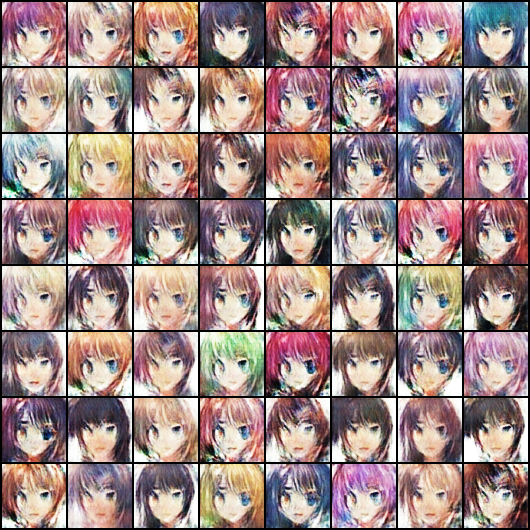

In [53]:
Image("./generated/generated-images-0005.png")

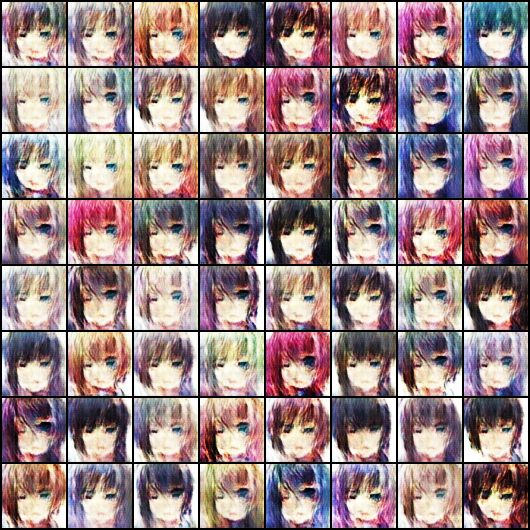

In [54]:
Image("./generated/generated-images-0007.png")

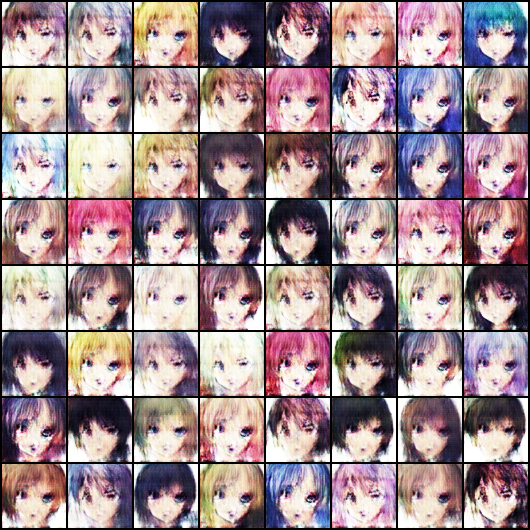

In [71]:
Image("./generated/generated-images-0009.png")

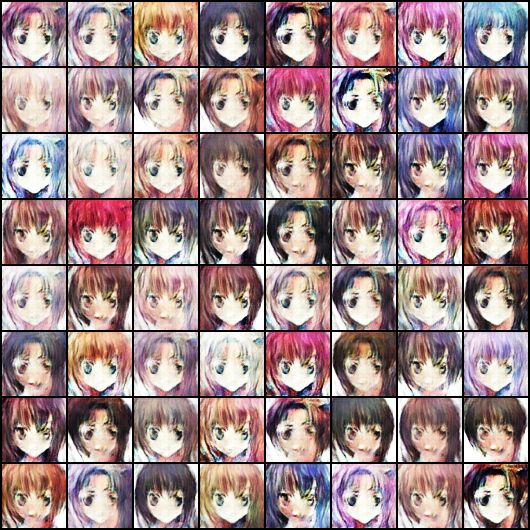

In [72]:
Image("./generated/generated-images-0010.png")

In [57]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [58]:
# Save Experiment

In [75]:
!ls /content/drive/MyDrive/Python/"Machine Learning"/ZeroToGANS_Revision

'1. PyTorch Basics: Tensors and Gradients.ipynb'
'2. Gradient Descent and Linear Regression w  PyTorch.ipynb'
'3. Working with Images and Logistic Regression.ipynb'
'4. Training Deep Neural Networks on a GPU.ipynb'
'5. Image Classification with CNNs.ipynb'
'6. Data Augmentation, ResNets, and Regularization.ipynb'
'7. Generative Adversarial Network - GANS'
 Assignments
 D.pth
 gans_training.avi
 generated
 G.pth
'Transfer Learning PyTorch.ipynb'


In [74]:
!cp -r ./generated /content/drive/MyDrive/Python/"Machine Learning"/ZeroToGANS_Revision/generated

In [70]:
!ls -a ./

.  ..  animefacedataset  .config  drive  generated  kaggle.json  sample_data
